# Visualization of portfolio policies for natural disaster experiment

This notebook helps visualize allocations by different portfolio policies to different clusters in the natural disaster experiment. We choose the portfolio obtained by the line search algorithm for $\alpha = 0.95$ for this visualization.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import sys
from matplotlib.patches import Rectangle
plt.rcParams['figure.dpi'] = 200
cwd = os.getcwd()
from pathlib import Path

project_root = os.path.join(Path.cwd(), '..', '..')
sys.path.insert(0, str(project_root))

from src.p_mean import generalized_p_mean, get_optimum_vector, generate_p_grid
from src.portfolio import (
    Policy, Portfolio, budget_portfolio_with_suboptimalities,
    portfolio_with_line_search, compute_portfolio_worst_approx_ratio,
    portfolio_of_random_policies, portfolio_of_random_norms,
    portfolio_with_gpi, gpi
)
import matplotlib.lines as mlines


# Generate the portfolio

In [75]:
# Load scores

suffices = ['.csv', '_bonus_5_0.1.csv', '_bonus_5_0.2.csv']

rewards_end = enumerate(suffices)

data_dict = {}

for index, suffix in rewards_end:

    scores = pd.read_csv(os.path.join('..', '..', 'data', 'natural_disaster', f'policy_rewards{suffix}'))
    scores = np.array(scores)
    scores = [scores[i] for i in range(len(scores))]
    

    # Initialize parameters
    d = len(scores[0])
    alpha=0.95

    # Functions
    def get_optimum_policy(p):
        return get_optimum_vector(vectors=scores, p=p)

    def get_performance(policy, p):
        return generalized_p_mean(x=policy, p=p)

    def get_optimal_value(p):
        return get_performance(Policy(get_optimum_policy(p)), p)

    # Compute portfolio
    line_search_portfolio = portfolio_with_line_search(
        get_optimum_policy=get_optimum_policy, get_performance=get_performance, alpha=alpha,
        d=d,
    )

    # Map p: policy
    line_search_portfolio = {
        line_search_portfolio.policies[i].p: line_search_portfolio.policies[i].id for i in range(len(line_search_portfolio))
    }
    data_dict[index] = line_search_portfolio

In [76]:
dict(rewards_end)

{}

# Plot

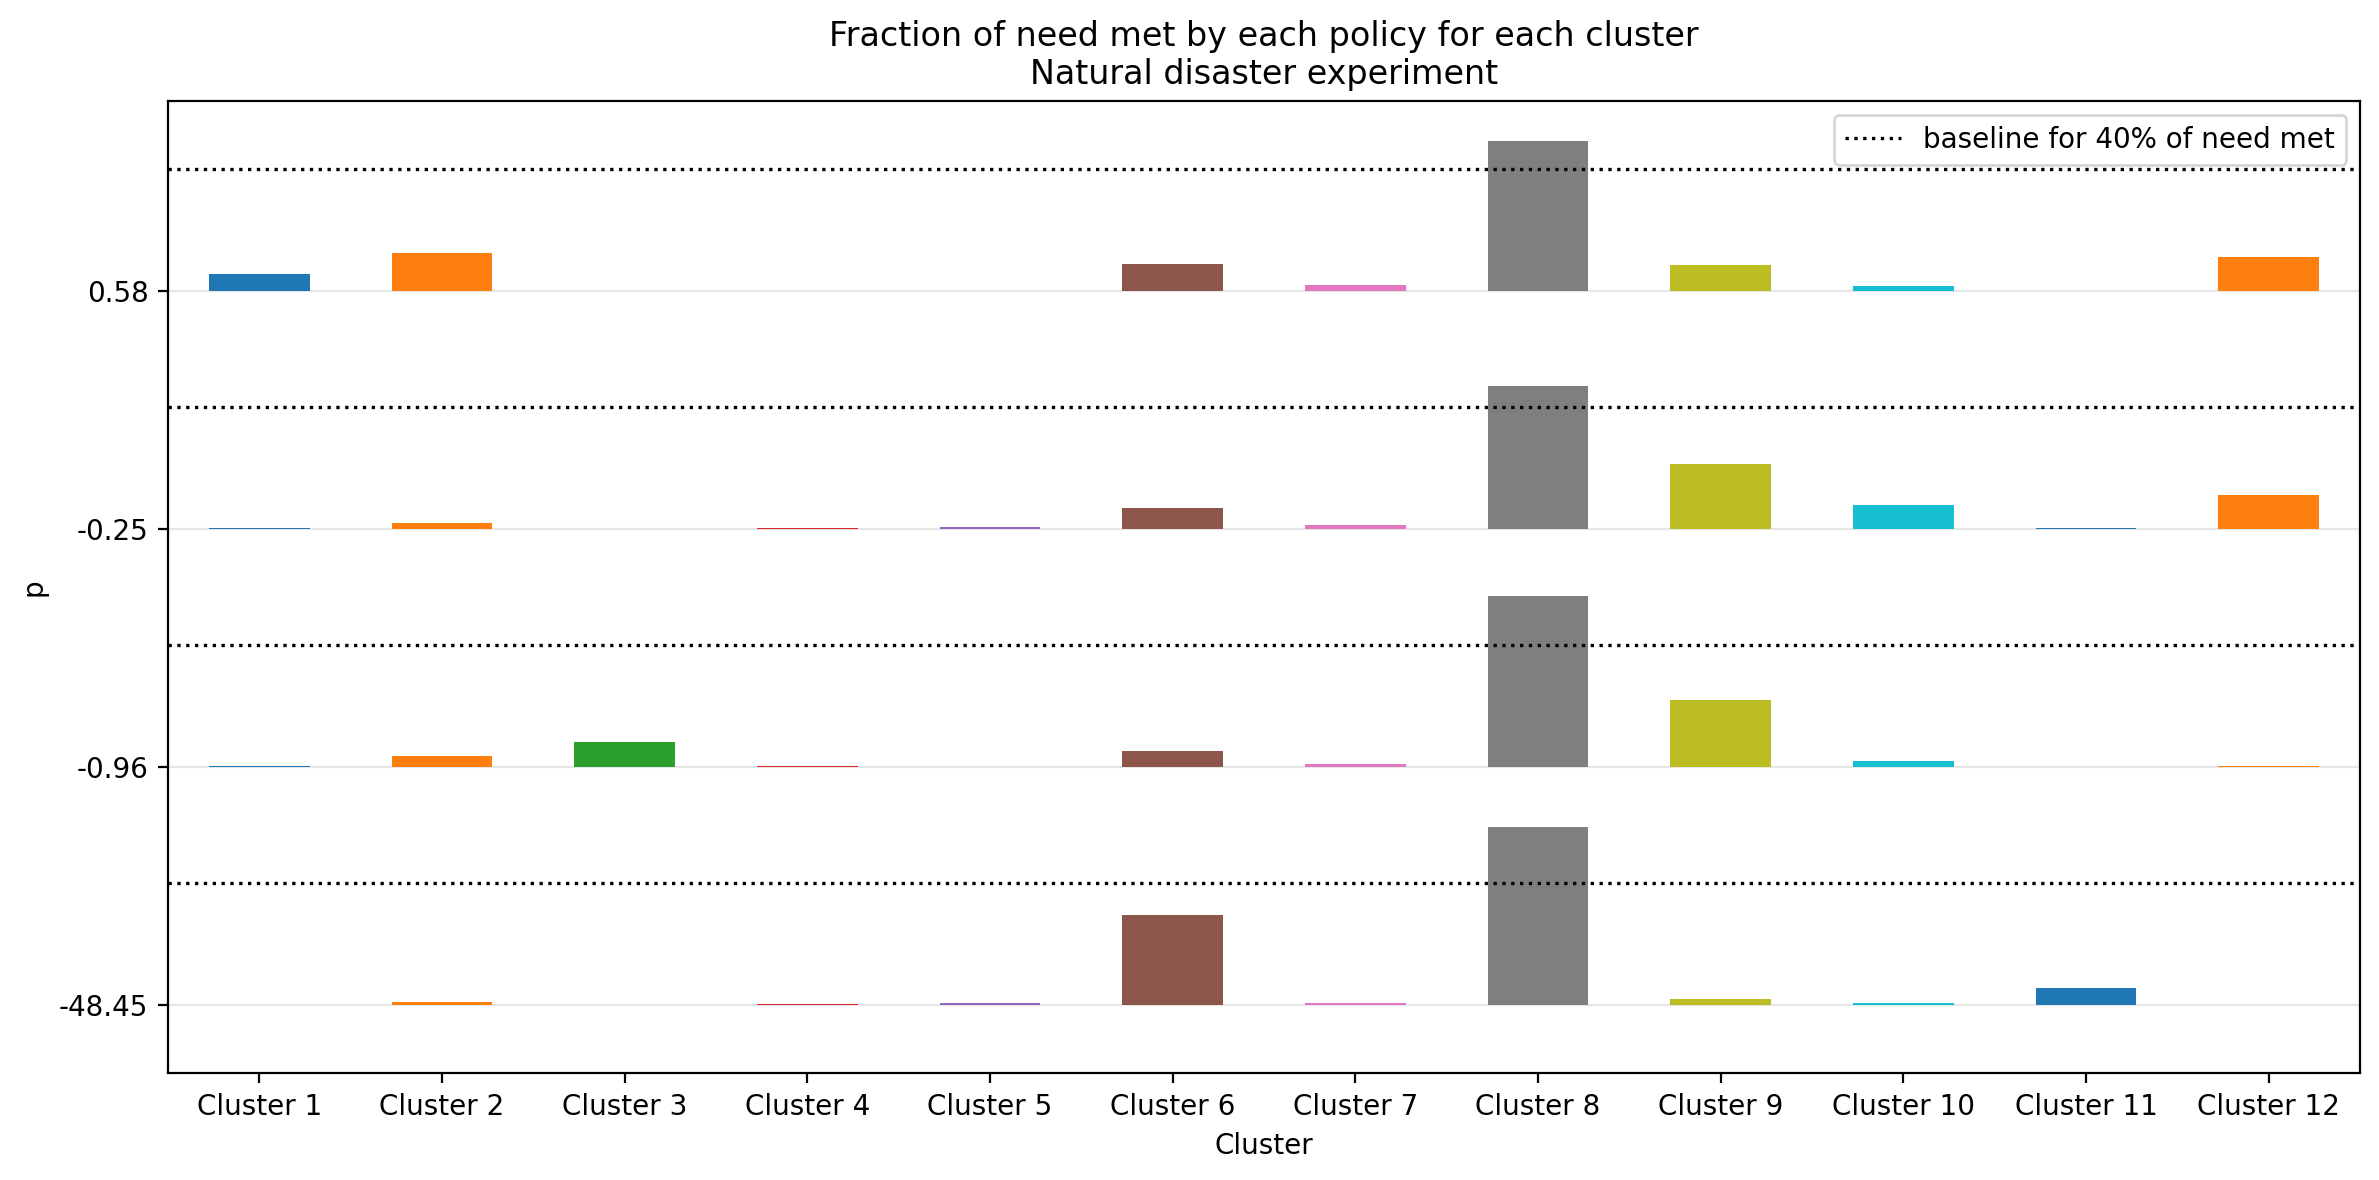

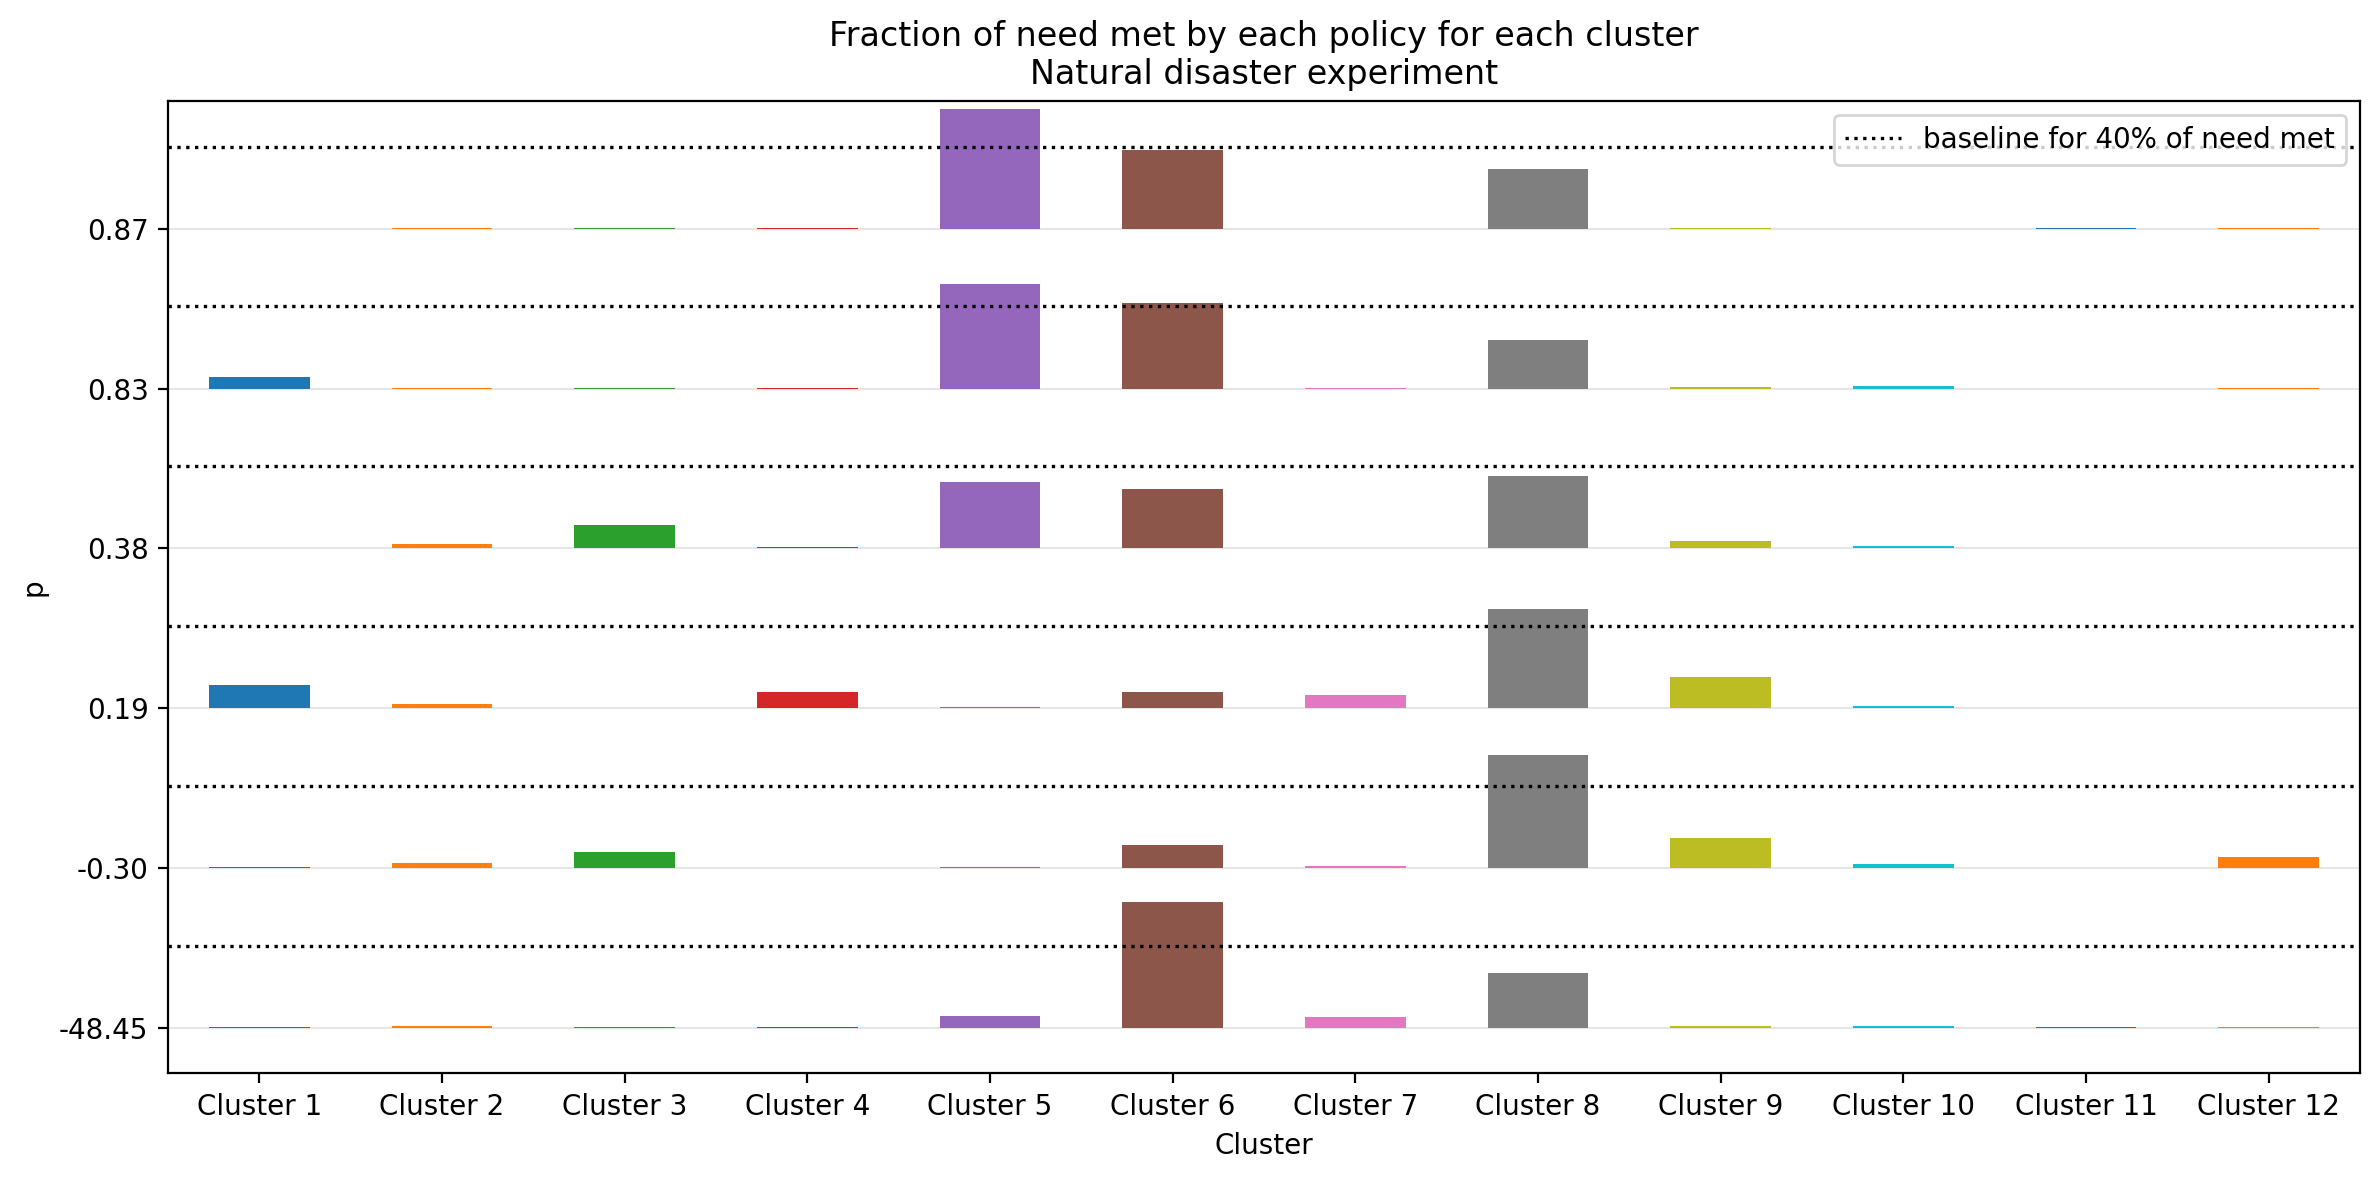

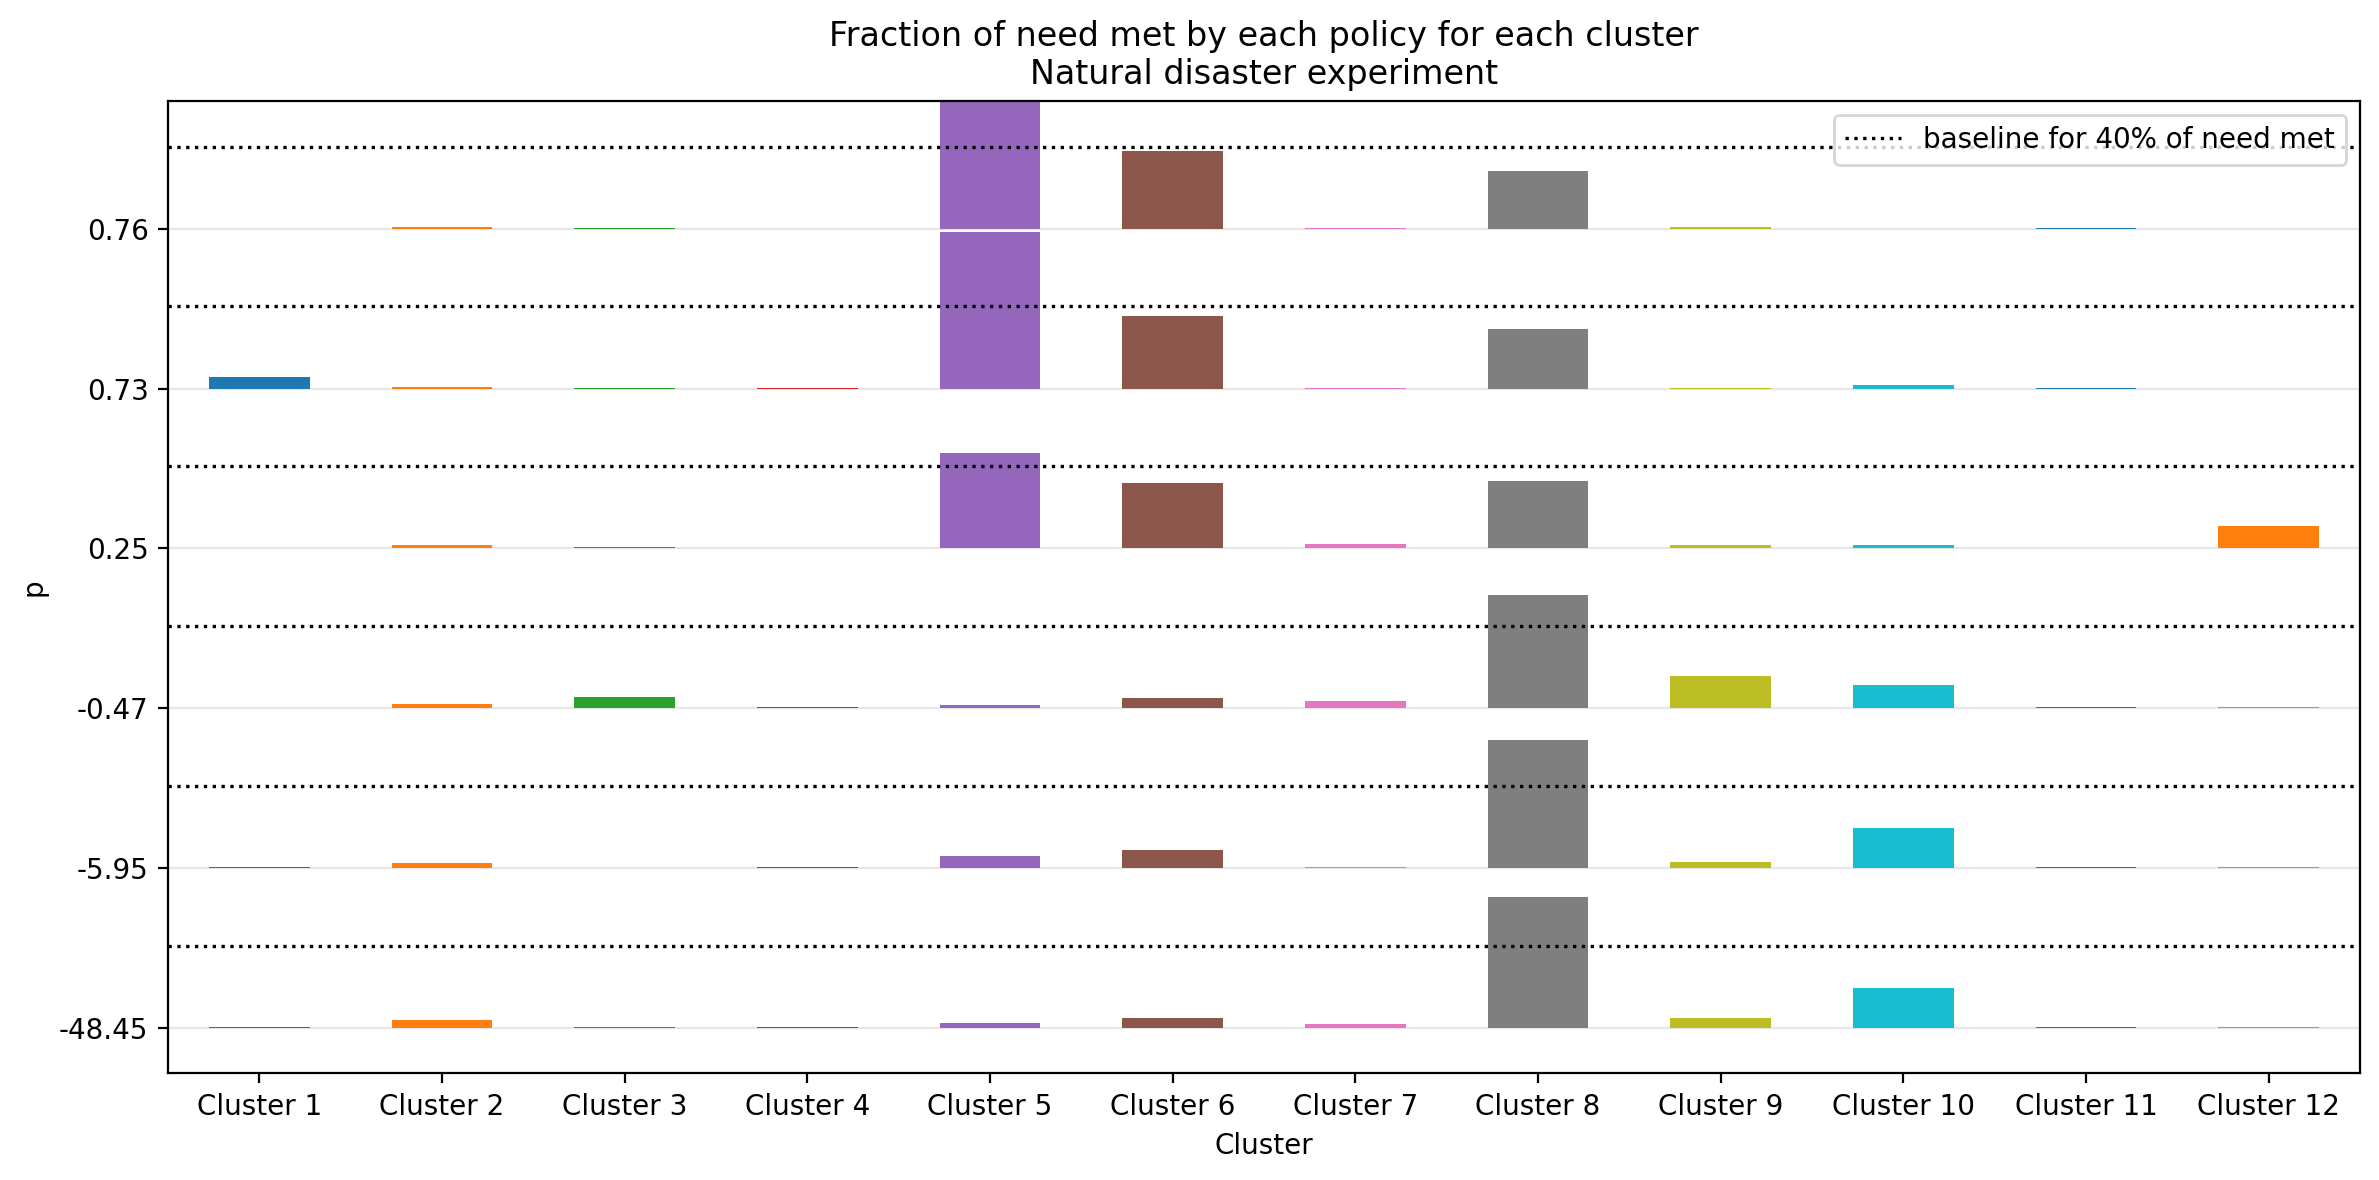

In [77]:
for i, line_search_portfolio in data_dict.items():
# --- reshape for plotting ---
    p_vals = list(line_search_portfolio.keys())
    m = len(p_vals)                       # number of p's (now y-axis)
    n = len(next(iter(line_search_portfolio.values())))  # clusters (now x-axis)

    need_met_bl = .4

    # values[i, j] = value for Cluster i at p index j
    values = np.column_stack([line_search_portfolio[p] for p in p_vals])
    vmax = values.max()

    fig, ax = plt.subplots(figsize=(12, 6))  # wide for clusters on x-axis

    row_spacing = 0.7  # < 1 means less vertical space between p-values
    col_w = 0.55          # width of each vertical bar
    x0 = 0.0
    y0 = 0.0
    ax.set_xlim(-0.5, n - 0.5)
    height_scale = 0.9  # same factor you use for bar height
    ax.set_ylim(-0.2, (m - 1) * row_spacing + need_met_bl * height_scale + 0.2)

    # color per cluster (consistent across p-values)
    cmap = plt.get_cmap('tab10')
    cluster_colors = [cmap(i % 10) for i in range(n)]

    # draw vertical bars
    for j in range(m):  # p index
        for i in range(n):  # cluster index
            x_center = i
            y_base = j * row_spacing
            h = values[i, j] * height_scale
            rect = Rectangle(
                (x_center - col_w / 2, y_base),  # bottom-left
                col_w, h,
                facecolor=cluster_colors[i],
                edgecolor='none'
            )
            ax.add_patch(rect)

    # ticks/labels
    ax.set_xticks(range(n))
    ax.set_xticklabels([f"Cluster {i+1}" for i in range(n)])
    ax.set_yticks([j * row_spacing for j in range(m)])
    ax.set_yticklabels([f"{p:.2f}" for p in p_vals])

    ax.set_ylabel("p")
    ax.set_xlabel("Cluster")
    ax.set_title("Fraction of need met by each policy for each cluster\nNatural disaster experiment")

    # horizontal guides and dotted baselines
    for j in range(m):
        y_base = j * row_spacing
        ax.axhline(y_base, color='0.9', lw=0.8, zorder=0)
        ax.hlines(y_base + need_met_bl * height_scale, -0.5, n - 0.5,
                  linestyles='dotted', colors='k', lw=1.2, zorder=5)

    # legend
    baseline_label = f"baseline for {need_met_bl*100:.0f}% of need met"
    baseline_handle = mlines.Line2D([], [], color='k', linestyle='dotted',
                                    linewidth=1.2, label=baseline_label)
    ax.legend(handles=[baseline_handle], loc='upper right')

    plt.tight_layout()
    plt.show()

Note: Clusters 2, 4, 5, and 7 have fairly low (and constant) amounts of their need fraction that is met.

In [79]:
for i, line_search_portfolio in data_dict.items():
    suffix = suffices[i]
    p_vals = list(line_search_portfolio.keys())
    m = len(p_vals)                       # number of p's (now y-axis)
    n = len(next(iter(line_search_portfolio.values())))  # clusters (now x-axis)

    # values[i, j] = value for Cluster i at p index j
    values = np.column_stack([line_search_portfolio[p] for p in p_vals])
    vmax = values.max()

    fig, ax = plt.subplots(figsize=(12, 6))  # wide for clusters on x-axis

    col_w = 0.55          # width of each vertical bar
    x0 = 0.0
    y0 = 0.0
    ax.set_xlim(-0.5, n - 0.5)
    height_scale = 0.9  # same factor you use for bar height
    ax.set_ylim(-0.2, m - 0.8 + height_scale)  # gives the top row room

    # color per cluster (consistent across p-values)
    cmap = plt.get_cmap('tab10')
    cluster_colors = [cmap(i % 10) for i in range(n)]

    # draw vertical bars
    for j in range(m):                 # p index (now y-axis position)
        for i in range(n):             # cluster index (now x-axis position)
            x_center = i
            h = (values[i, j] / vmax) * height_scale
            rect = Rectangle(
                (x_center - col_w / 2, j),  # bottom-left: start at p's axis line
                col_w, h,
                facecolor=cluster_colors[i],
                edgecolor='none'
            )
            ax.add_patch(rect)

    # ticks/labels
    ax.set_xticks(range(n))
    ax.set_xticklabels([f"Cluster {i+1}" for i in range(n)], size=12)
    ax.set_yticks(range(m))
    ax.set_yticklabels([f"{p:.2f}" for p in p_vals], size = 12)



    ax.set_ylabel("p", size=14)
    ax.set_xlabel("Cluster", size=14)
    ax.set_title("Fraction of need met by each policy for each cluster:\nNatural disaster experiment", size=16)
    ax.tick_params(axis='x', labelrotation=30)

    # light horizontal guides for p-values
    for j in range(m):
        ax.axhline(j, color='0.9', lw=0.8, zorder=0)
    # ax.grid(axis='x', color='0.95')

    plt.tight_layout()
    plt.savefig(os.path.join('..','..', 'figs', 'natural_disaster', f'policy_bars{suffix[:-4]}.png'))
    plt.close()

[]